In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

%matplotlib inline

Option to download via api and json

In [4]:
#url = 'https://data.cdc.gov/resource/xkkf-xrst.json'
#df = pd.read_json(url)
#df.tail(75)
#df.to_csv('covid_excess_deaths_usa_1.csv')

Clean up the data and do some visual checks on data

In [5]:
df = pd.read_csv(r'C:\Users\alexd\Downloads\fred_cpi_ui_int.csv')
df.dtypes
df.head()
display(df.isna().any())

df = df.set_index('obs_date')
df.drop('unemp_rate', axis =1, inplace=True)
df.head()
#x = df['cpi']
#y = df['cons_loan_interest']
#plt.plot(x, y, '.', color ='cadetblue', label='CPI vs Ave House Price')
#plt.xlabel('CPI')
#plt.ylabel('Loan Interest')

obs_date              False
unemp_rate            False
cpi                   False
cons_loan_interest    False
dtype: bool

,cpi,cons_loan_interest
obs_date,,
1972-01-01,41.333,9.96
1972-04-01,41.600,9.96
1972-07-01,41.933,10.02
1972-10-01,42.367,10.02
1973-01-01,43.033,10.05


Use built in correlation method to do a check

In [6]:
df.corr() 

,cpi,cons_loan_interest
cpi,1.00000,-0.83636
cons_loan_interest,-0.83636,1.00000


Check on std statistics from the describe method

In [7]:
df.describe()

,cpi,cons_loan_interest
count,205.000000,205.000000
mean,159.897600,8.878829
std,68.768757,3.214043
min,41.333000,4.000000
25%,105.300000,6.430000
50%,160.800000,8.700000
75%,217.934000,11.070000
max,299.023000,17.360000


array([[<AxesSubplot:title={'center':'cpi'}>,
        <AxesSubplot:title={'center':'cons_loan_interest'}>]],
      dtype=object)

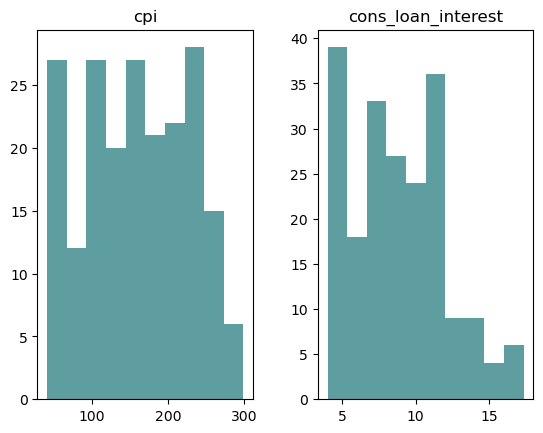

In [8]:
df.hist(grid = False, color = 'cadetblue')

Kurtosis is the pointiness of the data and skewness is the symmetry of the data around the peak

In [9]:
cpi_kurtosis = kurtosis(df['cpi'], fisher = True)
loan_kurtosis = kurtosis(df['cons_loan_interest'], fisher = True)

cpi_skew = skew(df['cpi'])
loan_skew = skew(df['cons_loan_interest'])

display("CPI Kurtosis: {:.2}".format(cpi_kurtosis))
display("Loans Kurtosis: {:.2}".format(loan_kurtosis))

display('CPI Skew: {:.2}'.format(cpi_skew))
display('Loans Skew: {:.2}'.format(loan_skew))

'CPI Kurtosis: -1.1'

'Loans Kurtosis: -0.35'

'CPI Skew: -0.026'

'Loans Skew: 0.45'

Kurtosis and skewness test for the variable. These will increase as pop'n size increases

In [10]:

display('CPI')
display(stats.kurtosistest(df['cpi']))
display(stats.skewtest(df['cpi']))

display('Loan Interst')
display(stats.kurtosistest(df['cons_loan_interest']))       
display(stats.skewtest(df['cons_loan_interest']))       

'CPI'

KurtosistestResult(statistic=-6.755356203100705, pvalue=1.4248476164333782e-11)

SkewtestResult(statistic=-0.15958241638434725, pvalue=0.8732100311458437)

'Loan Interst'

KurtosistestResult(statistic=-1.0419434948040647, pvalue=0.2974378770943763)

SkewtestResult(statistic=2.5846965820237866, pvalue=0.009746472585593484)

Split df into Y = output and X = input for modelling
train and test

In [11]:
Y = df.drop('cpi', axis=1)
X = df.drop('cons_loan_interest', axis=1)

#print(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_model.get_params()


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [12]:
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

pd.DataFrame(zip(X.columns, regression_model.coef_))


,0,1
0,cpi,[-0.03793068551263477]


Have to put this here otherwise the coefficient in the cell above won't show

In [14]:
print(' Regression model intercept is:', regression_model.intercept_)

 Regression model intercept is: [14.88069867]


Run model using X_test and look at the first 5 predictions

In [15]:
y_predict = regression_model.predict(X_test)

y_predict[:5]

array([[ 9.69936703],
       [ 8.94833946],
       [ 6.648602  ],
       [11.16349149],
       [11.29245582]])

Using SKLEARN for this evaluation
Remodel our regression using OLS method Ordinary Least Squares method

In [16]:
X2 = sm.add_constant(X)
model = sm.OLS(Y, X2)
est = model.fit()

Run some confidence intervals at 95% std because we are using sample n and n# ot population N

In [17]:
est.conf_int()

,0,1
const,14.512164,15.745952
cpi,-0.042634,-0.035543


Hypothesis testing Null is that there is no relationship between CPI and Consumer Loan Interest
Desired p_value is < 0.05. If the p_values is < 0.05 we can reject the null and accept the alternate hypothesis
p_value here is well under 0.05 so the null can be rejected and we can conclude there is a relationship between CPI and Consumer Loan Interest

In [18]:
est.pvalues

const    2.311681e-113
cpi       6.694916e-55
dtype: float64

Use metrics to determine how will the model predicts the actuals by taking the residual difference between prediction and actual

Mean Absolute Error MAE how big the magnitude of the error is
Mean Squared Error MSE the mean of the squared errors exagerates larger errors with the squaring
Root Mean Squared Error RMSE is the root of the mean of the squared errors in y-units

In [19]:
# MAE
model_mae = mean_absolute_error(y_test, y_predict)

# MSE
model_mse = mean_squared_error(y_test, y_predict)

# RMSE
model_rmse = math.sqrt(model_mse)

# Print results
print('MAE is {:.3}'.format(model_mae))
print('MSE is {:.3}'.format(model_mse))
print('RMSE is {:.3}'.format(model_rmse))

MAE is 1.41
MSE is 3.89
RMSE is 1.97


R-squared measures the goodness of fit. The higher the R^2 the better the fit
Adjusted R^2 is preferred for larger models where the model size influences R^2
R^2 here is 0.71 meaning data explains 71% of the variance

In [20]:
model_r2 = r2_score(y_test, y_predict)
print('R-Squared is {:.2}'.format(model_r2))

R-Squared is 0.71


using STASMODEL.API for summary statistics for our modelling

In [21]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     cons_loan_interest   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     472.5
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           6.69e-55
Time:                        09:26:55   Log-Likelihood:                -406.49
No. Observations:                 205   AIC:                             817.0
Df Residuals:                     203   BIC:                             823.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1291      0.313     48.356      0.0

Plot the residuals to see how they look e.g. normal dist'n?

<function matplotlib.pyplot.show(close=None, block=None)>

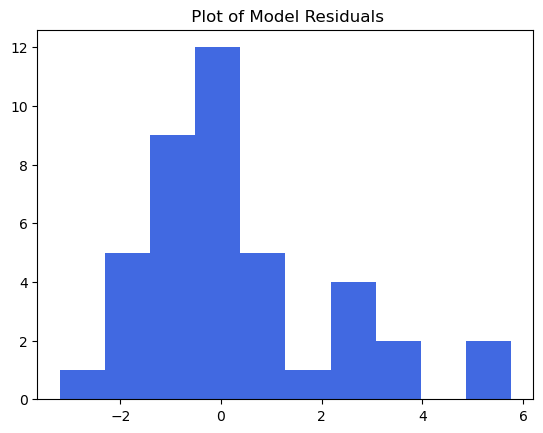

In [22]:
(y_test - y_predict).hist(grid=False, color = 'royalblue')
plt.title(' Plot of Model Residuals')
plt.show

Plot the mmodel line

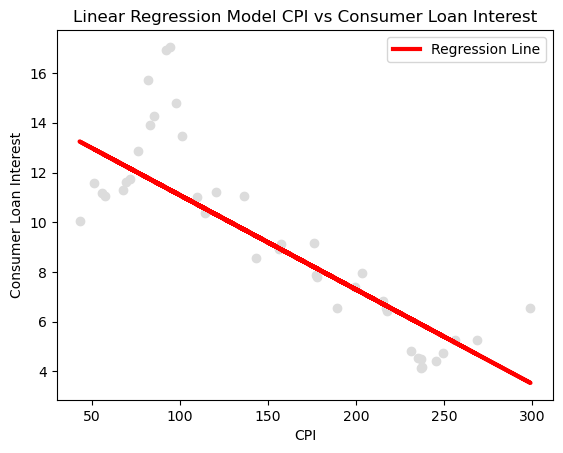

In [23]:


plt.scatter(X_test, y_test, color = 'gainsboro') 
plt.plot(X_test, y_predict, color = 'red', linewidth = 3, linestyle = '-', label = 'Regression Line')
plt.title('Linear Regression Model CPI vs Consumer Loan Interest')
plt.xlabel('CPI')
plt.ylabel('Consumer Loan Interest')
plt.legend()
plt.show()



In [24]:
# pickling our model for future use
import pickle

#save pickle
with open('basic_linear_regression_model.sav', 'wb') as f:
    pickle.dump(regression_model, f)
    
# reload model
with open('basic_linear_regression_model.sav', 'rb') as f:
    regression_model_2 = pickle.load(f)
    
regression_model_2.predict([[42.7]])
    

C:\Users\alexd\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[13.2610584]])